# Explainable AI: BAPC with Decision Trees
## Example with simulated data

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) # Navigate one folder up (from the 'notebooks' folder)
sys.path.append(os.path.abspath("C:/Users/dudkin/Documents/Projects/inAlco_ExplainableAI/bapcs_code/HDTree/hdtree"))
from helper_functions import *
%matplotlib inline

# Preparation
For the BAPC workflow we need to prepare two JSON files, with all the specification parameters.

```- read_simulated_data.json```

```- read_dec_tree_parameters.json```

### Example JSON File `read_simulated_data.json`
```json
{ "dir_to" : "C:/Users/dudkin/Documents/Projects/inAlco_ExplainableAI/bapcs_code/Speedinvest2/results_OneDrive/",
  "dir_data" : "C:/Users/dudkin/Documents/Projects/inAlco_ExplainableAI/bapcs_code/Speedinvest2/results_OneDrive/230926_simulated_data32/simulated_data32_2feat_3classes.xlsx",
  "save_to_foldername": "230926_simulated_data32",
  "name_to_save" : "simulated_data32",
  "which_feature_set" : ["feat1", "feat2"],
  "ylabel" : "Expert Opinion (Overall Performance)",
  "person_id_label" : "Company ID"
}
```
### Explanation of parameters in `read_simulated_data.json`
- ``dir_to ``: _str_. The directory where the results should be saved.
- ``dir_data ``: _str_. The directory where the input data is located.
- ``save_to_foldername ``: _str_. The name of the folder where the results will be saved.
- ``name_to_save ``: _str_. The name to use when saving the results.
- ``which_feature_set ``: _list of 2 str_. A list containing the names of two features to be used in the analysis.
- ``ylabel ``: _str_. The column name in the data file that contains the target (y-label) values.
- ``person_id_label``: _str_. The column name in the data file that contains the unique IDs for each data point.
- 
### Example JSON File `read_dec_tree_parameters.json`
```json
{ "circle_radius_factor": 2,
  "randomstate": 40,
  "trainingset": 95,
  "max_depth": 2,
  "min_samples_leaf": 2,
  "min_samples_split": 2,
  "which_cost_fct": "RelativeAccuracyMeasure",
  "do_upsamplin": false,
  "ccp_alpha": 0
}
```
### Explanation of parameters in `read_dec_tree_parameters.json`
- ``circle_radius_factor ``: _float_. Circle radius for error amplification.
- ``randomstate ``: _int_. Random generator number for random forest classifier.
- ``trainingset ``: _int_. Percentage, how much of the data should be used for the trainingset.
- ``max_depth ``: int. Maximal depth for decision trees in base model.
- ``min_samples_leaf ``: _int_. Minimum number of samples per leaf in decision tree.
- ``min_samples_split ``: _int_. Minimum number of samples for splits in decision tree.
- ``which_cost_fct``: _str_. Which cost function to use. Eiter "RelativeAccuracyMeasure" (hdtree) or "Gini" (scikit-learn)
- ``do_upsamplin``: _boolean_. If datapoints should be upsampled.
- ``ccp_alpha``: _int_. cost complexity parameter for pruning technique in decision tree.


## Read JSON files

In [2]:
prepath = "C:/Users/dudkin/Documents/Projects/inAlco_ExplainableAI/bapcs_code/Speedinvest2/"
json_dec_tree_params = prepath + "base_model/Algorithms_Dez2023/read_dec_tree_parameters.json"
# Read Simulation Data.
json_data_dir = prepath + 'base_model/Algorithms_Dez2023/read_simulated_data.json'
    
# In order to find the person_id_to_check:
# run the script: get_person_id.py.
person_id_to_check = 286
simdata = True
show_figure = True
all_features = False
plot_hyperbola = False
circle_radius_l = 2


In [3]:
# Read data specifications from json-file.
data_specs = read_data_specs(json_data_dir)
# Read Decision Tree Parameters from JSON
dec_tree_parameters = read_dec_tree_params(json_dec_tree_params)

# Get list of features (either from data_specs JSON file, or all features)
list_features = get_features(data_specs, all_features)
# i_list_feat: Defines the pair of features to use for the analysis. 
# You can also specify multiple pairs as a list of lists, e.g., [["feat1", "feat2"], ["feat1", "feat3"]]. 
# This variable determines which pair from the list will be selected for further analysis.
i_list_feat = 0     

alpha = 0.5  # transparency parameter for plotting the scatter data points

### Preprocess Data
The data is read and split into a training set and a test set, with the corresponding y-labels stored in a dictionary called ``x_y_dict``.

The ``df_y`` dataframe contains the true y-labels, the datapoint IDs, and the x-coordinates for the selected features. During further analysis, this dataframe will be expanded to include predictions from models such as Decision Tree 1, the AI model, Decision Tree 3, and others.
``df_y_test`` is the corresponding dataframe for the test-dataset.

In [4]:
# Preprocess data, generate trainingset & testset (x_y_dict)
data_specs, \
    x_y_dict, df_y, \
    df_y_test, \
    datapoint_of_interest,\
    circle_radius_factor = preprocess_data(data_specs,
                                            list_features,
                                            i_list_feat,
                                            person_id_to_check,
                                            simdata,
                                            dec_tree_parameters,
                                            circle_radius_l)

C:/Users/dudkin/Documents/Projects/inAlco_ExplainableAI/bapcs_code/Speedinvest2/results_OneDrive/230926_simulated_data32\person_id_286\feat1__feat2
Features: 
['feat1', 'feat2']
DATAPOINT OF INTEREST (TRAIN): [2.454057081733112, 2.380610367715676]


In [5]:
df_y

,y_train,Company ID,feat1,feat2
0,0,204,2.292142,4.558356
1,1,71,6.498193,0.983013
2,1,594,4.029325,0.463996
3,1,672,4.958805,1.456907
4,0,14,2.27958,5.298823
...,...,...,...,...
946,0,939,6.683394,2.180248
947,0,505,2.343526,6.076151
948,1,343,6.319093,0.071407
949,1,430,4.104477,0.431723


## Step 1 of BAPC.
Do predictions with base model with the first decision tree.

In [6]:
 # ####################################################
# ############### STEP 1 #############################
# ####################################################
# Run STEP 1 of BAPC, Prediction with Decision Tree 1.
hdtree_linear, df_y, \
    df_y_test, df_accuracies = bapc_step1(dec_tree_parameters,
                                            x_y_dict,
                                            df_y,
                                            df_y_test)

The results are stored in ``df_y``, which includes the predicted y-labels from the first decision tree (`y_predicted_hdtree1`). 
The variable ``epsilon`` represents the error made by the first decision tree when compared to the true data labels.

In [7]:
df_y

,y_train,Company ID,feat1,feat2,y_predicted_hdtree1,leaf_id_DT1,epsilon
0,0,204,2.292142,4.558356,0.0,3,0
1,1,71,6.498193,0.983013,1.0,1,0
2,1,594,4.029325,0.463996,1.0,1,0
3,1,672,4.958805,1.456907,1.0,1,0
4,0,14,2.27958,5.298823,0.0,3,0
...,...,...,...,...,...,...,...
946,0,939,6.683394,2.180248,0.0,3,0
947,0,505,2.343526,6.076151,0.0,3,0
948,1,343,6.319093,0.071407,1.0,1,0
949,1,430,4.104477,0.431723,1.0,1,0


## Plot the data with the predictions of first decision tree. 

The red cross depicts the datapoint of interest, for which we want an explanation, why this datapoint was predicted to be in class label 0, and which features it could change, in order to shift into a class prediction label 1.

C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2703: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors,


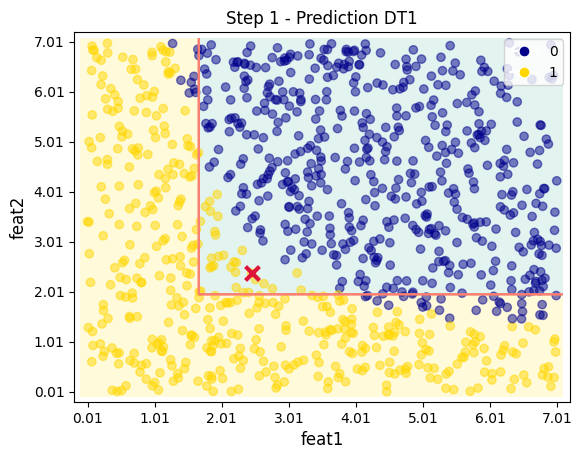

In [8]:
# Plot Data with Decision Boundary STEP 1
rec_regions_x, rec_regions_y, ax, fig, _, _ = \
    plot_decision_boundary(hdtree_linear,
                           x_y_dict["x_train"],
                           x_y_dict["y_train"],
                           data_specs["save_to_folder"],
                           dec_tree_parameters,
                           datapoint_of_interest,
                           plot_color_area=True,
                           which_step="step1",
                           fs=12,
                           title="Step 1 - Prediction DT1",
                           cmap='Set3',
                           alpha=alpha,
                           show_figure=show_figure)

## Step 2
In the second step, an AI model (here: Random Forest Classifier) predicts the error which was made by the first decision tree (``epsilon``).


In [9]:
# --------------------------------------------
# ------------- STEP 2 -----------------------
# --------------------------------------------
df_y, df_y_test, df_accuracies, \
    predicted_rf_tr, predicted_rf_test, \
    surr_predict, surr_predict_test, model_rf = \
    step2(x_y_dict,
          dec_tree_parameters,
          df_accuracies,
          df_y, df_y_test)

              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.99        34
         0.0       1.00      1.00      1.00       887
         1.0       1.00      1.00      1.00        30

    accuracy                           1.00       951
   macro avg       0.99      1.00      0.99       951
weighted avg       1.00      1.00      1.00       951

Mean Absolute Error epsilon-epsilon_tilde: 0.001
accuracy test data y_test & surrogate-predict-test 0.98
accuracy training data y_train & surrogate-predict 0.999


In [10]:
df_y

,y_train,Company ID,feat1,feat2,y_predicted_hdtree1,leaf_id_DT1,epsilon,y_predicted_DT1+AI=y_pred_DT1+epsilon_hat,epsilon_hat
0,0,204,2.292142,4.558356,0.0,3,0,0.0,0.0
1,1,71,6.498193,0.983013,1.0,1,0,1.0,0.0
2,1,594,4.029325,0.463996,1.0,1,0,1.0,0.0
3,1,672,4.958805,1.456907,1.0,1,0,1.0,0.0
4,0,14,2.27958,5.298823,0.0,3,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
946,0,939,6.683394,2.180248,0.0,3,0,0.0,0.0
947,0,505,2.343526,6.076151,0.0,3,0,0.0,0.0
948,1,343,6.319093,0.071407,1.0,1,0,1.0,0.0
949,1,430,4.104477,0.431723,1.0,1,0,1.0,0.0


**Plot** ``epsilon`` and ``epsilon_hat`` - the prediction of the AI model.

C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2703: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors,
C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\venv2\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2508: UserWarning: TODO: We have more than 1 boundary in x-direction. TO CHECK...
  warnings.warn("TODO: We have more than 1 boundary in x-direction. "
C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2511: UserWarning: TODO: We have more than 1 boundar

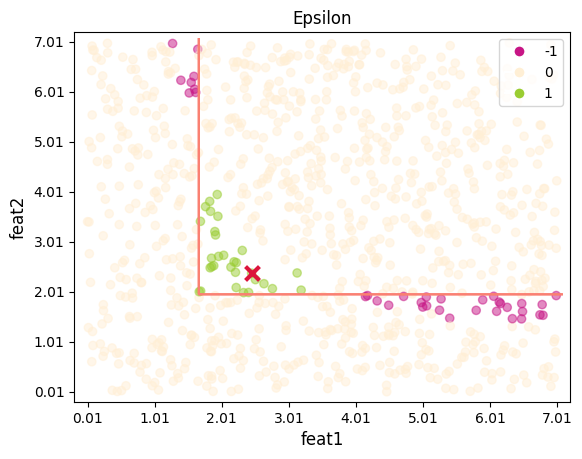

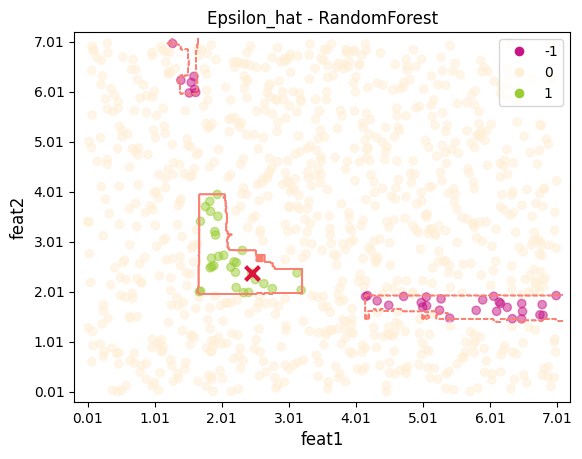

In [11]:
# Plot Epsilon
_, _, _, _, _, _ = plot_decision_boundary(hdtree_linear,
                                   x_y_dict["x_train"],
                                   df_y.loc[:, "epsilon"],
                                   dec_tree_parameters["save_to_folder"],
                                   dec_tree_parameters,
                                   datapoint_of_interest,
                                   plot_color_area=False,
                                   which_step="error_ampl",
                                   fs=12,
                                   title="Epsilon",
                                   cmap='Set3',
                                   alpha=alpha,
                                   show_figure=show_figure)
# Plot Epsilon_hat
_, _, _, _, _, _ = plot_decision_boundary(model_rf,
                       x_y_dict["x_train"],
                       df_y["epsilon_hat"],
                       dec_tree_parameters["save_to_folder"],
                       dec_tree_parameters,
                       datapoint_of_interest,
                       plot_color_area=False,
                       which_step="error_ampl",
                       fs=12,
                       title="Epsilon_hat - RandomForest",
                       cmap='Set3',
                       alpha=alpha,
                       show_figure=show_figure)

## Error Amplification
This step involves expanding the neighborhood around the predicted error (``epsilon_hat``) and relabeling data points accordingly:

- A circular neighborhood is created around the datapoint of interest, with the radius ``circle_radius_factor``.
- All points within this extended circular neighborhood are relabeled to match the ``epsilon_hat`` value of the datapoints in the neighborhood of the datapoint of interest.

In [12]:
# -----------------------------------------------------------
# ############## ERROR AMPLIFICATION #################
# -----------------------------------------------------------
df_y, df_y_big, circle_radius, \
    rec_oi_x, rec_oi_y = error_amplification(datapoint_of_interest,
                                             x_y_dict["x_train"],
                                             hdtree_linear,
                                             data_specs,
                                             df_y,
                                             circle_radius_factor,
                                             circle_around_one_point=True,
                                             testdata = False)

rectangle_of_interest_x:
[1.6604342658007274, 7.07041158008201]
rectangle_of_interest_y:
[1.9504115800820128, 7.080434265800725]


C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2703: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors,


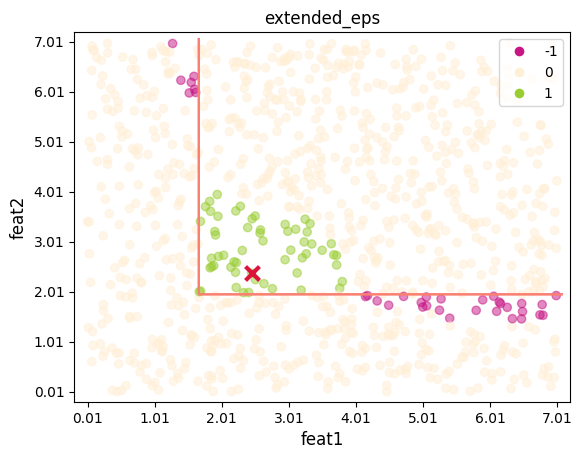

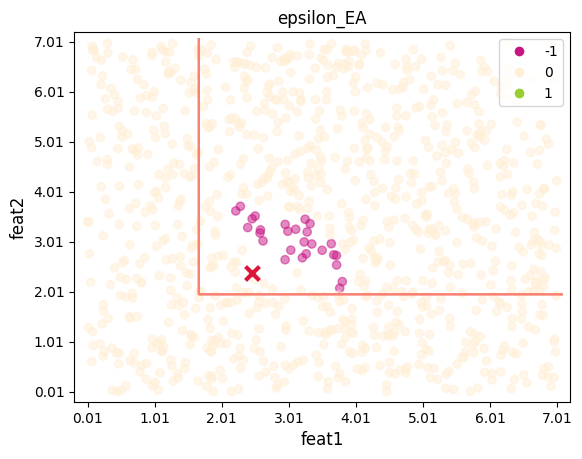

In [13]:
_, _, _, _, _, _ = plot_decision_boundary(hdtree_linear,
                                   x_y_dict["x_train"],
                                   df_y.loc[:, "extended_eps"],
                                   dec_tree_parameters["save_to_folder"],
                                   dec_tree_parameters,
                                   datapoint_of_interest,
                                   plot_color_area=False,
                                   which_step="error_ampl",
                                   fs=12,
                                   title="extended_eps",
                                   cmap='Set3',
                                   alpha=alpha,
                                   show_figure=show_figure)
_, _, _, _, _, _ = plot_decision_boundary(hdtree_linear,
                                   x_y_dict["x_train"],
                                   df_y.loc[:, "eps_EA"],
                                   dec_tree_parameters["save_to_folder"],
                                   dec_tree_parameters,
                                   datapoint_of_interest,
                                   plot_color_area=False,
                                   which_step="error_ampl",
                                   fs=12,
                                   title="epsilon_EA",
                                   cmap='Set3',
                                   alpha=alpha,
                                   show_figure=show_figure)

## Step 3
- Modify the labels of the input data with ``Y + epsilon_EA``.
- Train the base model (decision tree) on this modified dataset
- Retrieve new decision boundaries based on the modified dataset, generated with the error amplification.

In [14]:
# --------------------------------------------
# ------------- STEP 3 -----------------------
# --------------------------------------------

hdtree_linear_s3, df_y, df_y_big, \
    df_y_test, df_accuracies = bapc_step3(dec_tree_parameters,
                                          data_specs,
                                          x_y_dict,
                                          df_y,
                                          df_y_big,
                                          df_y_test,
                                          df_accuracies)

C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:1007: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y["y_predicted_hdtree" + which_step] = hdtree_linear.predict(x_train.values).astype(float)
C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:1012: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y["leaf_id_DT" + which_step] = None
C:\Users\dudkin

## Modified Input data for Step 3

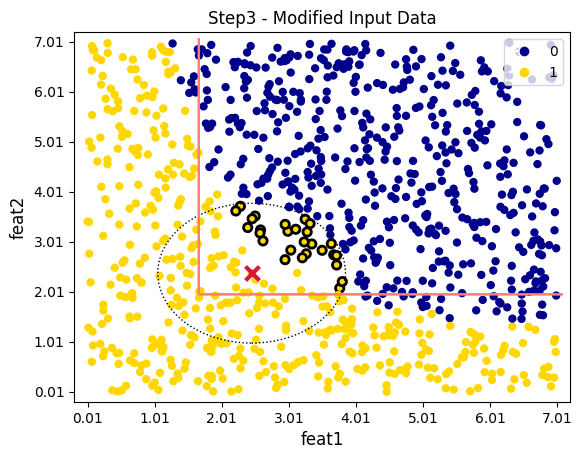

In [15]:
_, _, _, _, _, _ = plot_decision_boundary(hdtree_linear,
                                   x_y_dict["x_train"],
                                   df_y.loc[:, "y_epsilon_hat_ea"],
                                   dec_tree_parameters["save_to_folder"],
                                   dec_tree_parameters,
                                   datapoint_of_interest,
                                   edgecolor=df_y['edgecolor'],
                                   circle_radius=circle_radius,
                                   plot_color_area=False,
                                   which_step="step3",
                                   fs=12,
                                   title="Step3 - Modified Input Data",
                                   cmap='Set3',
                                   alpha=alpha,
                                   show_figure=show_figure)

## Plot results of Step 3
Modified decision boundaries (green).

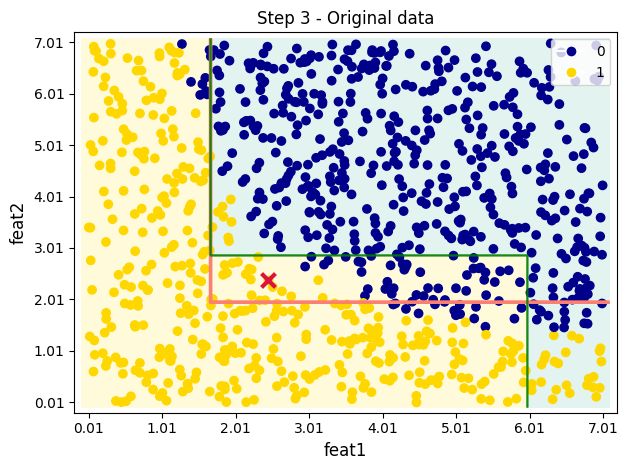

In [16]:
edgecolor = []
_, _ = plot_decision_boundary_two_dbound(hdtree_linear, hdtree_linear_s3,
                                              x_y_dict["x_train"],
                                              x_y_dict["y_train"],
                                              dec_tree_parameters["save_to_folder"],
                                              dec_tree_parameters,
                                              edgecolor,
                                              datapoint_of_interest,
                                              circle_radius=None,
                                              plot_color_area=True,
                                              plot_hyperbola=plot_hyperbola,
                                              plot_distance_to_hyperbola=False,
                                              which_step="step3",
                                              fs=12,
                                              title="Step 3 - Original data",
                                              cmap='Set3',
                                              figsize=(6.4, 4.8),
                                              show_figure=show_figure)

## Feature Importance

C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:2508: UserWarning: TODO: We have more than 1 boundary in x-direction. TO CHECK...
  warnings.warn("TODO: We have more than 1 boundary in x-direction. "


rectangle_of_interest_x:
[0.0, 5.9704342658007254]
rectangle_of_interest_y:
[0.0, 2.860411580082012]
datapoint_of_interest:
[2.454057081733112, 2.380610367715676]
minimal rectangle around datapoint_oi-X:
[1.6604342658007274, 5.9704342658007254]  --> datapoint_oi-x-value = 2.454057081733112
minimal rectangle around datapoint_oi-Y:
[1.9504115800820128, 2.860411580082012]  --> datapoint_oi-y-value = 2.380610367715676
['mediumaquamarine', 'lightcoral']
mediumaquamarine


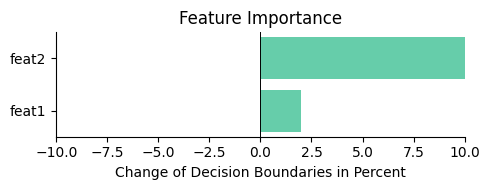

In [17]:
# -----------------------------
# FEATURE IMPORTANCES
# -----------------------------
change_dec_boundary_l, \
    change_dec_boundary_l_old,\
    rec_around_x_oi, rec_around_y_oi = bapc_feature_importance(data_specs,
                                                x_y_dict,
                                                df_y_big,
                                                hdtree_linear,
                                                hdtree_linear_s3,
                                                datapoint_of_interest,
                                                rec_oi_x,
                                                rec_oi_y)
# -------------------------
# PLOT FEATURE IMPORTANCES
# -------------------------
colors = ['mediumaquamarine', 'lightcoral']
title = "Feature Importance"
xlabel = 'Change of Decision Boundaries in Percent'
if show_figure:
    fig_barplot, ax_barplot_change_db = plot_bar_change_of_decision_bound(
        change_dec_boundary_l, data_specs["K_featnames"],
        data_specs["save_to_folder"], dec_tree_parameters,
        title, xlabel,
        colors, show_figure, xlim=[-10, 10])

## Fidelity

In [18]:
# --------------------------------------
# ############# FIDELITY ###############
# --------------------------------------
df_y_big, df_y_in_rectangle_circle, \
    df_y_in_rectangle, df_y_full_circle, \
    df_summary_fidelity = bapc_fidelity(data_specs,
                                        df_y_big,
                                        datapoint_of_interest,
                                        rec_around_x_oi,
                                        rec_around_y_oi)

fidelity: 0.328
FIDELITY RATIO, only points within circled neighborhood + Schnitt rectangle = 0.696969696969697


C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:1328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_in_rectangle["DT3-DT1-epsilon_hat"] = np.abs(- df_y_in_rectangle["DT1-DT3"] - \
C:\Users\dudkin\Documents\Projects\inAlco_ExplainableAI\bapcs_code\Speedinvest2\base_model\Algorithms_Dez2023\helper_functions.py:1330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_in_rectangle["DT3-DT1-epsilon"] = np.abs(- df_y_in_rectang

## Plot results with Fidelity and R^2 values.

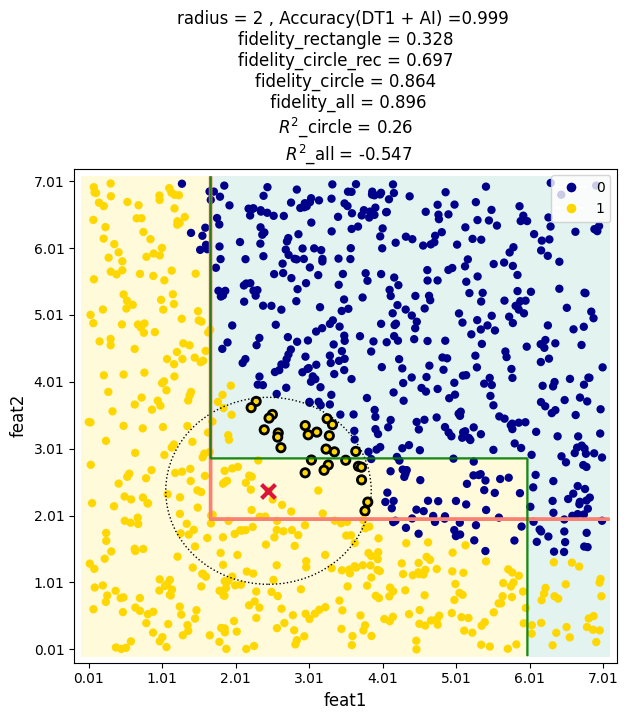

In [19]:
_, _ = plot_decision_boundary_two_dbound(hdtree_linear, hdtree_linear_s3,
                                              x_y_dict["x_train"],
                                              df_y["y_epsilon_hat_ea"],
                                              data_specs["save_to_folder"],
                                              dec_tree_parameters,
                                              df_y['edgecolor'],
                                              datapoint_of_interest,
                                              circle_radius,
                                              plot_color_area=True,
                                              plot_hyperbola=plot_hyperbola,
                                              plot_distance_to_hyperbola=plot_hyperbola,
                                              which_step="step3",
                                              fs=12,
                                              title="radius = " + str(circle_radius_factor) + " , Accuracy(DT1 + AI) =" +
                                                    str(df_accuracies.loc["acc_train", "DT1 + AI"]) +
                                                    " \nfidelity_rectangle = " +
                                                    str(round(df_summary_fidelity.at[0, 'Fidelity_rectangle'], 3)) +
                                                    "\nfidelity_circle_rec = " +
                                                    str(round(df_summary_fidelity.at[0, 'Fidelity_circle_rec'], 3)) +
                                                    "\nfidelity_circle = " +
                                                    str(round(df_summary_fidelity.at[0, 'Fidelity_circle'], 3)) +
                                                    "\n fidelity_all = " +
                                                    str(round(df_summary_fidelity.at[0, 'Fidelity_all'], 3)) +
                                                    "\n" +
                                                    r"$R^2$_circle = " + str(round(df_summary_fidelity.at[0, 'R2_circle'], 2)) +
                                                    "\n" +
                                                    r" $R^2$_all = " + str(round(df_summary_fidelity.at[0, 'R2_all'], 3)),
                                              cmap='Set3',
                                          figsize=(6.4, 7.3),
                                              show_figure=True)